### Preprocessing for Bassez et al., 2021 (PMID: 33958794)

### Prerequisites

In [ ]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
import os
import scvi
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.settings.verbosity = 3            
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)

### Tidy up data

In [ ]:
from scipy.sparse import csr_matrix
mtx = pd.read_csv('../yourpath/cells_cohort1_matrix.csv', index_col=0).T
mtx_sparse = csr_matrix(mtx.values)
md = pd.read_csv('../yourpath/1872-BIOKEY_metaData_cohort1_web.csv.xls', index_col='Cell')
adata = anndata.AnnData(X=mtx_sparse, obs=md, var=pd.DataFrame(index=mtx.columns))

mtx = pd.read_csv('../yourpath/cells_cohort2_matrix.csv').T
mtx.columns = mtx.iloc[0]
mtx = mtx[1:]
md = pd.read_csv('../yourpath/1871-BIOKEY_metaData_cohort2_web.csv.xls')
md.index = md['Cell']
print(md.head(n=5))
bdata = anndata.AnnData(X=mtx.values, obs=md, var=pd.DataFrame(index=mtx.columns))
adata_merged = anndata.concat([adata, bdata], join='outer')
adata_merged.write('../yourpath.h5ad')

### QC

In [ ]:
###Load data
DATA_KEY = '../yourpath.h5ad'
adata = sc.read_h5ad(DATA_KEY)

###functions
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

###QC
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.filter_cells(adata, min_genes = 10) 
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train(accelerator="cpu", devices=1)
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train(accelerator="cpu", devices=1)
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df['dif'] = df.doublet - df.singlet
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
adata = sc.read_h5ad(DATA_KEY)
print(f"Total number of cells: {adata.n_obs}")
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata = adata[~adata.obs.doublet]
print(f"Number of cells after filtering of doublets: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.filter_cells(adata, min_genes = 200) 
adata.var['mt'] = adata.var_names.str.startswith('MT-')
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=[20], log1p=True, inplace=True)
adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5) | is_outlier(adata, "pct_counts_in_top_20_genes", 5))
adata.obs.outlier.value_counts()
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 20)
adata.obs.mt_outlier.value_counts()
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

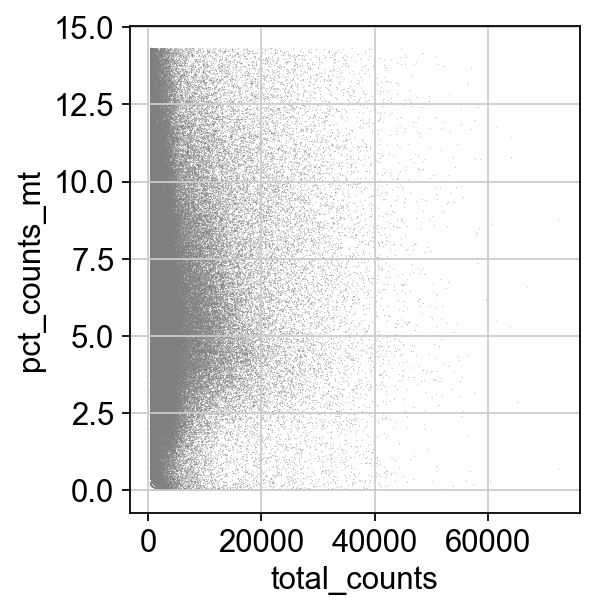

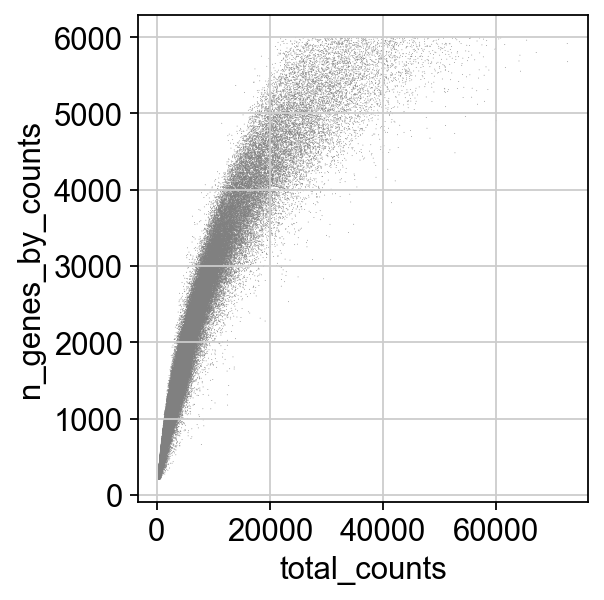

In [3]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata.write('../yourpath.h5ad')

### Annotation and metadata

In [ ]:
#Load data
adata = sc.read_h5ad('../yourpath.h5ad')

#Add annotation 1
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=6000, layer="counts", subset=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

scvi.model.SCVI.setup_anndata(adata, layer='counts',
                              batch_key='patient_id',
                              continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

model = scvi.model.SCVI(adata, n_layers=2, n_latent=30)
model.train(accelerator="cpu", devices=1)
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

In [ ]:
#Add annotation 2
cell_type = {
    '0':'T/NK cells',
    '1': 'T/NK cells',
    '2': 'Myeloid cells',
    '3': 'Epithelial cells (malignant)',
    '4': 'Fibroblasts',
    '5': 'Epithelial cells (malignant)',
    '6': 'Endothelial cells',
    '7': 'Epithelial cells (malignant)',
    '8': 'T/NK cells',
    '9': 'B cells',
    '10': 'T/NK cells',
    '11': 'Fibroblasts',
    '12': 'Fibroblasts',
    '13': 'Fibroblasts',
    '14': 'T/NK cells',
    '15': 'Epithelial cells (malignant)',
    '16': 'T/NK cells',
    '17': 'Epithelial cells (malignant)',
    '18': 'T/NK cells',
    '19': 'Epithelial cells (malignant)',
    '20': 'Epithelial cells (malignant)',
    '21': 'Epithelial cells (malignant)',
    '22': 'Fibroblasts',
    '23': 'Mast cells',
    '24': 'Epithelial cells (malignant)',
    '25': 'pDC',
    '26': 'Epithelial cells (malignant)',
    '27': 'Epithelial cells (malignant)',
    '28': 'Myeloid cells',
    '29': 'Epithelial cells (malignant)',
    '30': 'Myeloid cells',
    '31': 'Myeloid cells',
    '32': 'B cells',
    '33': 'Endothelial cells',
    '34': 'Myeloid cells',
}

adata.obs['anno'] = adata.obs.leiden.map(cell_type)
adata_anno = adata.obs['anno']
bdata = sc.read_h5ad(filename='../yourpath.h5ad')
bdata.obs['anno'] = adata_anno
bdata.obs['anno2'] = adata.obs['anno']

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:49)


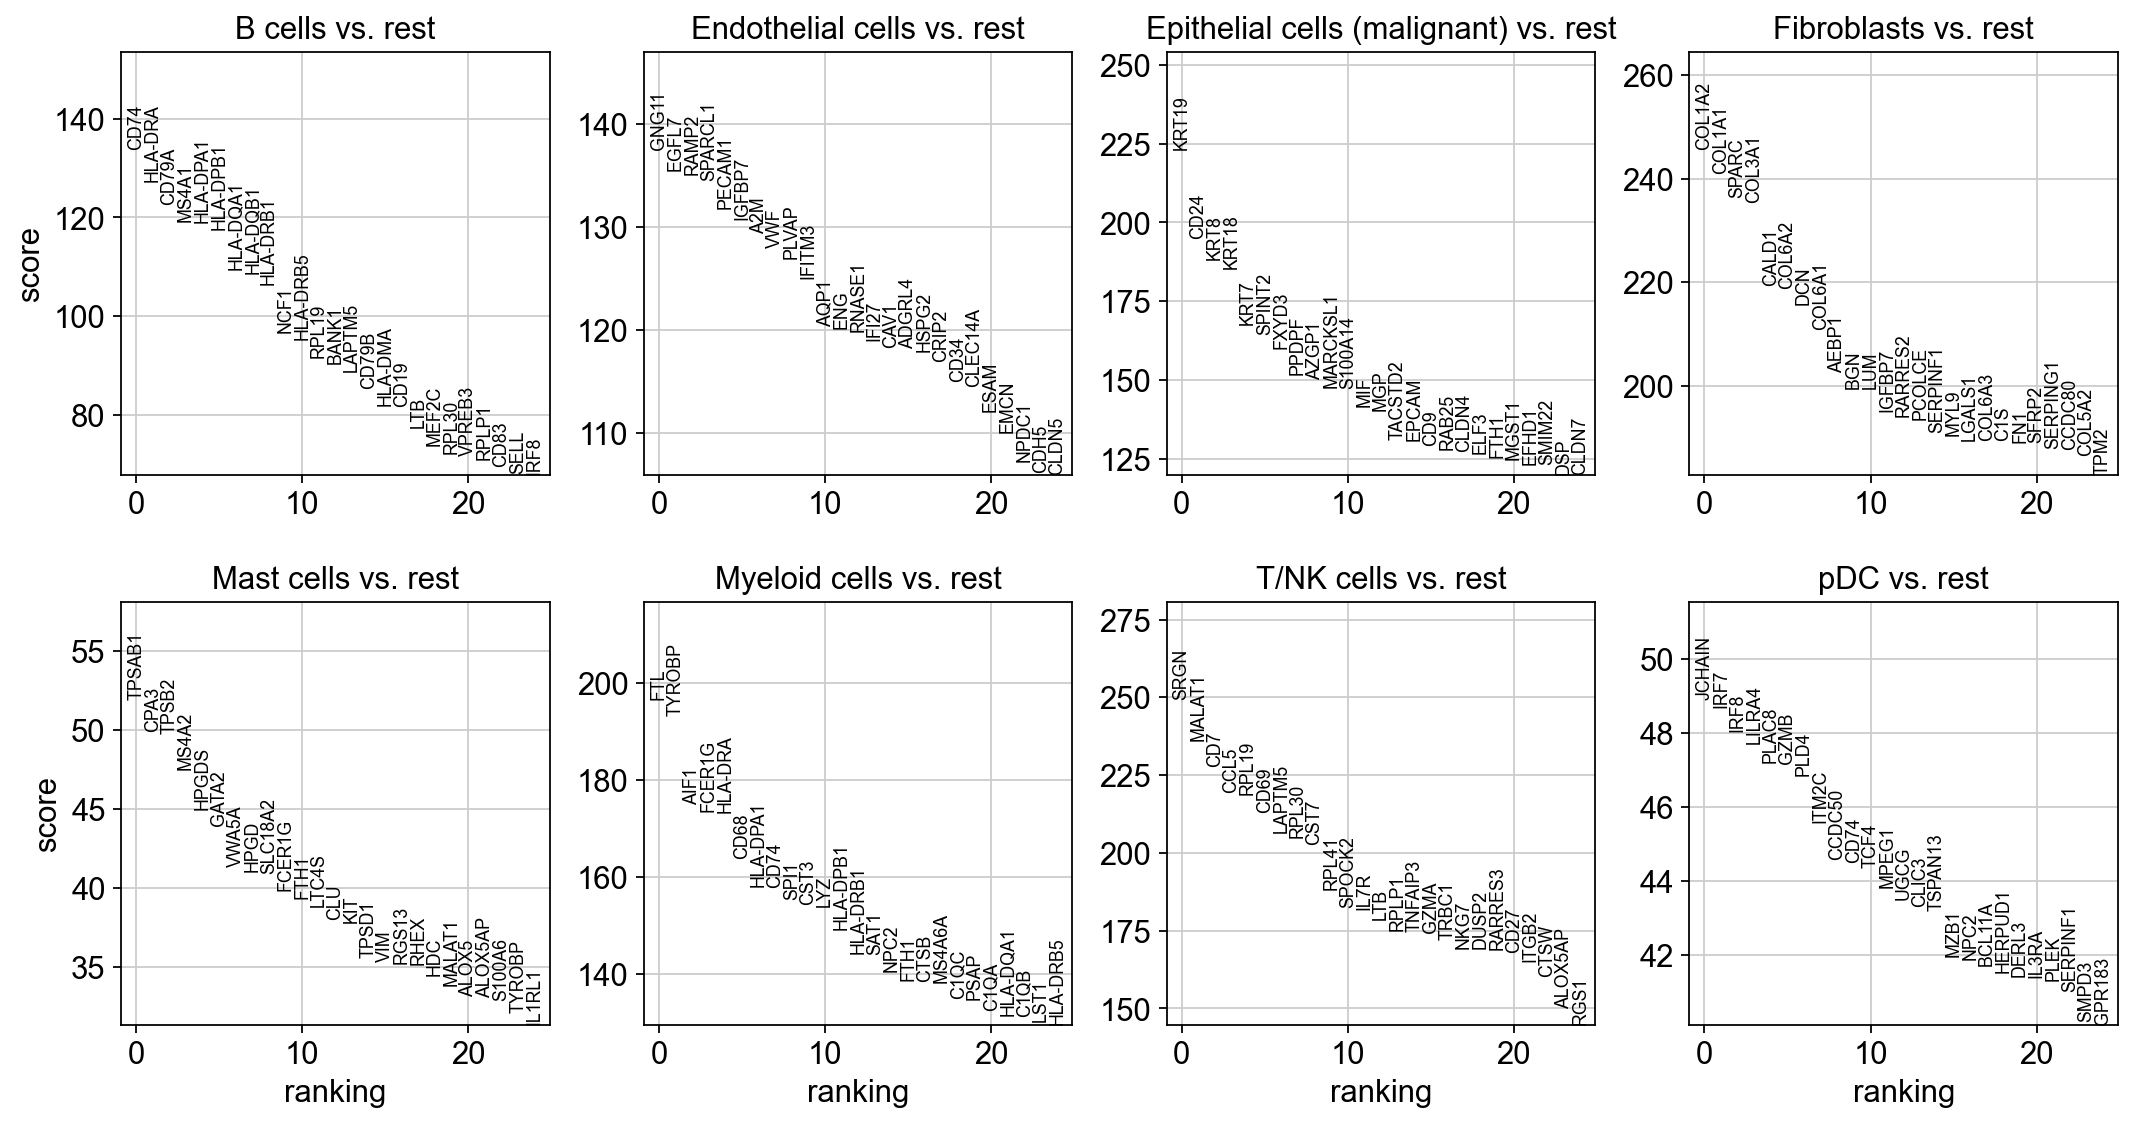

In [16]:
sc.tl.rank_genes_groups(adata, 'anno', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
#Add metadata
bdata.obs['sample'] = 'patient_id'
bdata.obsm['X_scVI'] = adata.obsm['X_scVI']
bdata.write('../yourpath.h5ad')